0      1995-12-25
1      1995-12-26
2      1995-12-27
3      1995-12-28
4      1995-12-29
          ...    
6767   2022-11-10
6768   2022-11-11
6769   2022-11-14
6770   2022-11-15
6771   2022-11-16
Name: Date, Length: 6772, dtype: datetime64[ns]
    Target Date    Target-3    Target-2    Target-1      Target
0    2020-11-12  141.000000  146.000000  150.949997  151.199997
1    2020-11-13  146.000000  150.949997  151.199997  146.350006
2    2020-11-14  150.949997  151.199997  146.350006  148.850006
3    2020-11-17  151.199997  146.350006  148.850006  158.000000
4    2020-11-18  146.350006  148.850006  158.000000  173.500000
..          ...         ...         ...         ...         ...
493  2022-11-10  425.350006  435.000000  433.149994  412.200012
494  2022-11-11  435.000000  433.149994  412.200012  423.500000
495  2022-11-14  433.149994  412.200012  423.500000  433.700012
496  2022-11-15  412.200012  423.500000  433.700012  437.149994
497  2022-11-16  423.500000  433.700012  437.14999

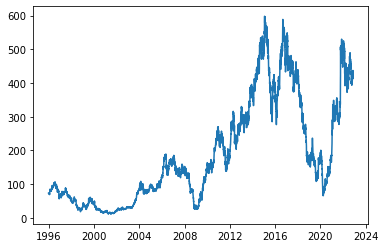

In [54]:
import pandas as pd

df = pd.read_csv("C:/Users/TRIPT/Downloads/tatamotors.csv")


df = df[['Date', 'Close']]

import datetime

def str_to_datetime(s):
  split = s.split('-')
  day, month, year = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(day=day, month=month, year=year)


df['Date'] = df['Date'].apply(str_to_datetime)
print(df['Date'])

df.index = df.pop('Date')
df

import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, 
                                '12-11-2020', 
                                '16-11-2022', 
                                n=3)
print(windowed_df)


def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]


print(X_train)


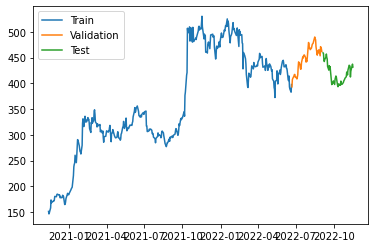

In [55]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [56]:
windowed_df.isnull().any() 

Target Date    False
Target-3       False
Target-2       False
Target-1       False
Target         False
dtype: bool

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(70),
                    layers.Dense(35, activation='relu'),
                    layers.Dense(35, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 [==============================] - 5s 75ms/step - loss: 140367.9531 - mean_absolute_error: 361.3084 - val_loss: 199329.2344 - val_mean_absolute_error: 445.7845
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 139265.5938 - mean_absolute_error: 359.7915 - val_loss: 197683.5469 - val_mean_absolute_error: 443.9348
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 137659.3125 - mean_absolute_error: 357.5472 - val_loss: 195228.2031 - val_mean_absolute_error: 441.1600
Epoch 4/100
13/13 [==============================] - 0s 8ms/step - loss: 134656.8438 - mean_absolute_error: 353.2523 - val_loss: 188998.5156 - val_mean_absolute_error: 434.0411
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 127919.6172 - mean_absolute_error: 343.5490 - val_loss: 178487.7656 - val_mean_absolute_error: 421.7598
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 118208.0469 - mean_absolute_error: 329.06

In [59]:
train_predictions = model.predict(X_train).flatten()


13/13 [==============================] - 0s 2ms/step


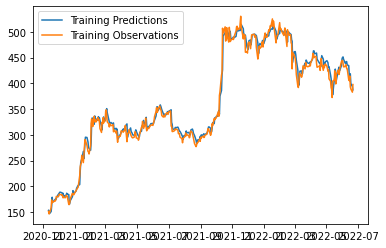

In [60]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])



2/2 [==============================] - 0s 3ms/step


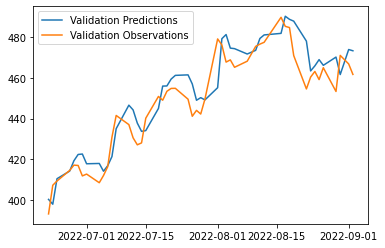

In [62]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])



2/2 [==============================] - 0s 3ms/step


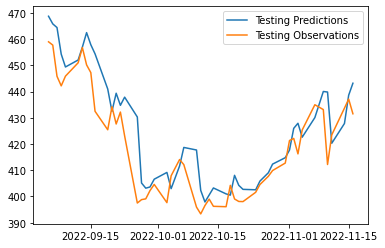

In [63]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])



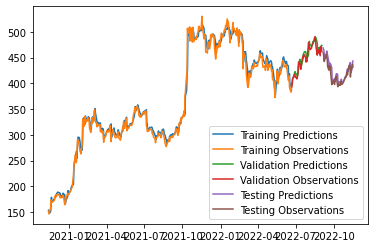

In [64]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])



1/1 [==============================] - 0s 28ms/step


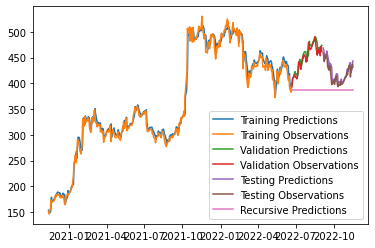

In [65]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction
  
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])